In [1]:
import json 
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
ROOT = "media"   # change if needed

# Fields to extract
FIELDS = [
    "mean_ng",
    "Nbw",
    "NDBP",
    "max_disp",
    "max_loss",
    "max_loss_ng2",
    "true_cost"
]

records = []   # list of dicts

for root, dirs, files in os.walk(ROOT):
    if "meta_data.json" in files:
        json_path = os.path.join(root, "meta_data.json")

        # Extract test identifiers
        parts = json_path.split(os.sep)
        test_name = parts[-2]              # e.g., "test0"
        loss_test = parts[-3]              # e.g., "loss_tests0"
        ndbp_index = parts[-4]              # e.g., "ndbp0"
        ng_dir = parts[-5]                 # e.g., "ng10"

        with open(json_path, "r") as f:
            data = json.load(f)

        # Store extracted values
        record = {
            "ng": ng_dir,
            "loss_group": loss_test,
            "ndbp": ndbp_index,
            "test": test_name
        }
        for key in FIELDS:
            record[key] = data.get(key, None)

        records.append(record)

# -----------------------------
# Convert to numpy structured array
# -----------------------------
dtype = [
    ("ng", "U32"),
    ("loss_group", "U32"),
    ("ndbp", "U32"),
    ("test", "U32"),
] + [(field, "f8") for field in FIELDS]

np_array = np.zeros(len(records), dtype=dtype)

for i, rec in enumerate(records):
    np_array[i]["ng"] = rec["ng"]
    np_array[i]["loss_group"] = rec["loss_group"]
    np_array[i]["ndbp"] = rec["ndbp"]
    np_array[i]["test"] = rec["test"]
    for field in FIELDS:
        np_array[i][field] = rec[field]

# Optional: also produce a pandas DataFrame
try:
    import pandas as pd
    df = pd.DataFrame(records)
except ImportError:
    df = None

# Preview
print("Extracted", len(records), "records.")
print(records[:2])       # sample
print(np_array[:2])      # numpy view


Extracted 14242 records.
[{'ng': 'ng24', 'loss_group': 'loss_tests11', 'ndbp': 'ndbp2', 'test': 'test16', 'mean_ng': 25.416226723161817, 'Nbw': 0.010364478799980722, 'NDBP': 0.26342594304771416, 'max_disp': 1907.4713711238446, 'max_loss': 8.312398963881133, 'max_loss_ng2': 0.012622839554340392, 'true_cost': 0.21605617181197725}, {'ng': 'ng24', 'loss_group': 'loss_tests11', 'ndbp': 'ndbp2', 'test': 'test11', 'mean_ng': 24.471112739672943, 'Nbw': 0.010251522461596156, 'NDBP': 0.250866161911009, 'max_disp': 1737.1654926236906, 'max_loss': 17.010493059447143, 'max_loss_ng2': 0.029086335059342404, 'true_cost': 0.2940058652357582}]
[('ng24', 'loss_tests11', 'ndbp2', 'test16', 25.41622672, 0.01036448, 0.26342594, 1907.47137112,  8.31239896, 0.01262284, 0.21605617)
 ('ng24', 'loss_tests11', 'ndbp2', 'test11', 24.47111274, 0.01025152, 0.25086616, 1737.16549262, 17.01049306, 0.02908634, 0.29400587)]


In [5]:
np_array

array([('ng24', 'loss_tests11', 'ndbp2', 'test16', 25.41622672, 0.01036448, 0.26342594, 1907.47137112,  8.31239896, 0.01262284, 0.21605617),
       ('ng24', 'loss_tests11', 'ndbp2', 'test11', 24.47111274, 0.01025152, 0.25086616, 1737.16549262, 17.01049306, 0.02908634, 0.29400587),
       ('ng24', 'loss_tests11', 'ndbp2', 'test18', 24.00624652, 0.01201007, 0.28831677, 4346.11750336,  5.58430596, 0.00981782, 0.4068947 ),
       ...,
       ('ng26', 'loss_tests13', 'ndbp1', 'test3', 27.14289745, 0.00901015, 0.24456165,  725.83998964, 12.10102901, 0.01634105, 0.08611184),
       ('ng26', 'loss_tests13', 'ndbp1', 'test2', 27.23505736, 0.00834821, 0.2273639 , 1877.00376083, 12.1557905 , 0.01598401, 0.1209783 ),
       ('ng26', 'loss_tests13', 'ndbp1', 'test5',  9.71120119, 0.02992822, 0.29063892, 7598.24745725,  0.71484502, 0.00453462, 1.12378657)],
      dtype=[('ng', '<U32'), ('loss_group', '<U32'), ('ndbp', '<U32'), ('test', '<U32'), ('mean_ng', '<f8'), ('Nbw', '<f8'), ('NDBP', '<f8'), ('

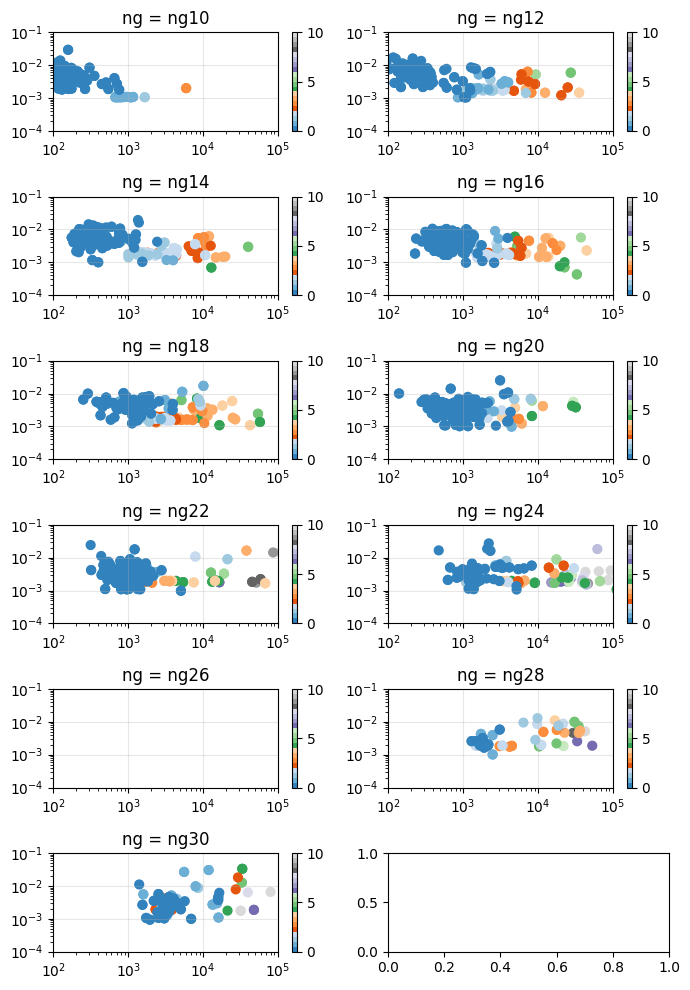

In [14]:
ng_strings = ["ng10","ng12","ng14","ng16","ng18","ng20","ng22","ng24","ng26","ng28","ng30"]

fig, axs = plt.subplots(6, 2, figsize=(7, 10))
for i, ng_string in enumerate(ng_strings):
    mask = (np_array["ng"] == ng_string) & (np_array["ndbp"] == "ndbp0")
    sub = np_array[mask]

    # Extract values
    x = sub["max_disp"]
    y = sub["max_loss_ng2"]
    c = sub["true_cost"]

    # Sort such that smaller c values appear last (on top)
    sort_idx = np.argsort(c)[::-1]  # sort descending so smallest c last (will be plotted last, appear "on top")
    x_sorted = x[sort_idx]
    y_sorted = y[sort_idx]
    c_sorted = c[sort_idx]

    axs[i//2, i%2].grid(True, alpha=0.3)
    sc = axs[i//2, i%2].scatter(x_sorted, y_sorted, c=c_sorted, s=40, cmap='tab20c', vmin=0, vmax=10)
    plt.colorbar(sc, ax=axs[i//2, i%2])

    axs[i//2, i%2].set_xscale("log")
    axs[i//2, i%2].set_yscale("log")
    axs[i//2, i%2].set_xlim(1e2, 1e5)
    axs[i//2, i%2].set_ylim(1e-4, 1e-1)
    axs[i//2, i%2].set_title(f"ng = {ng_string}")

plt.tight_layout()
plt.show()



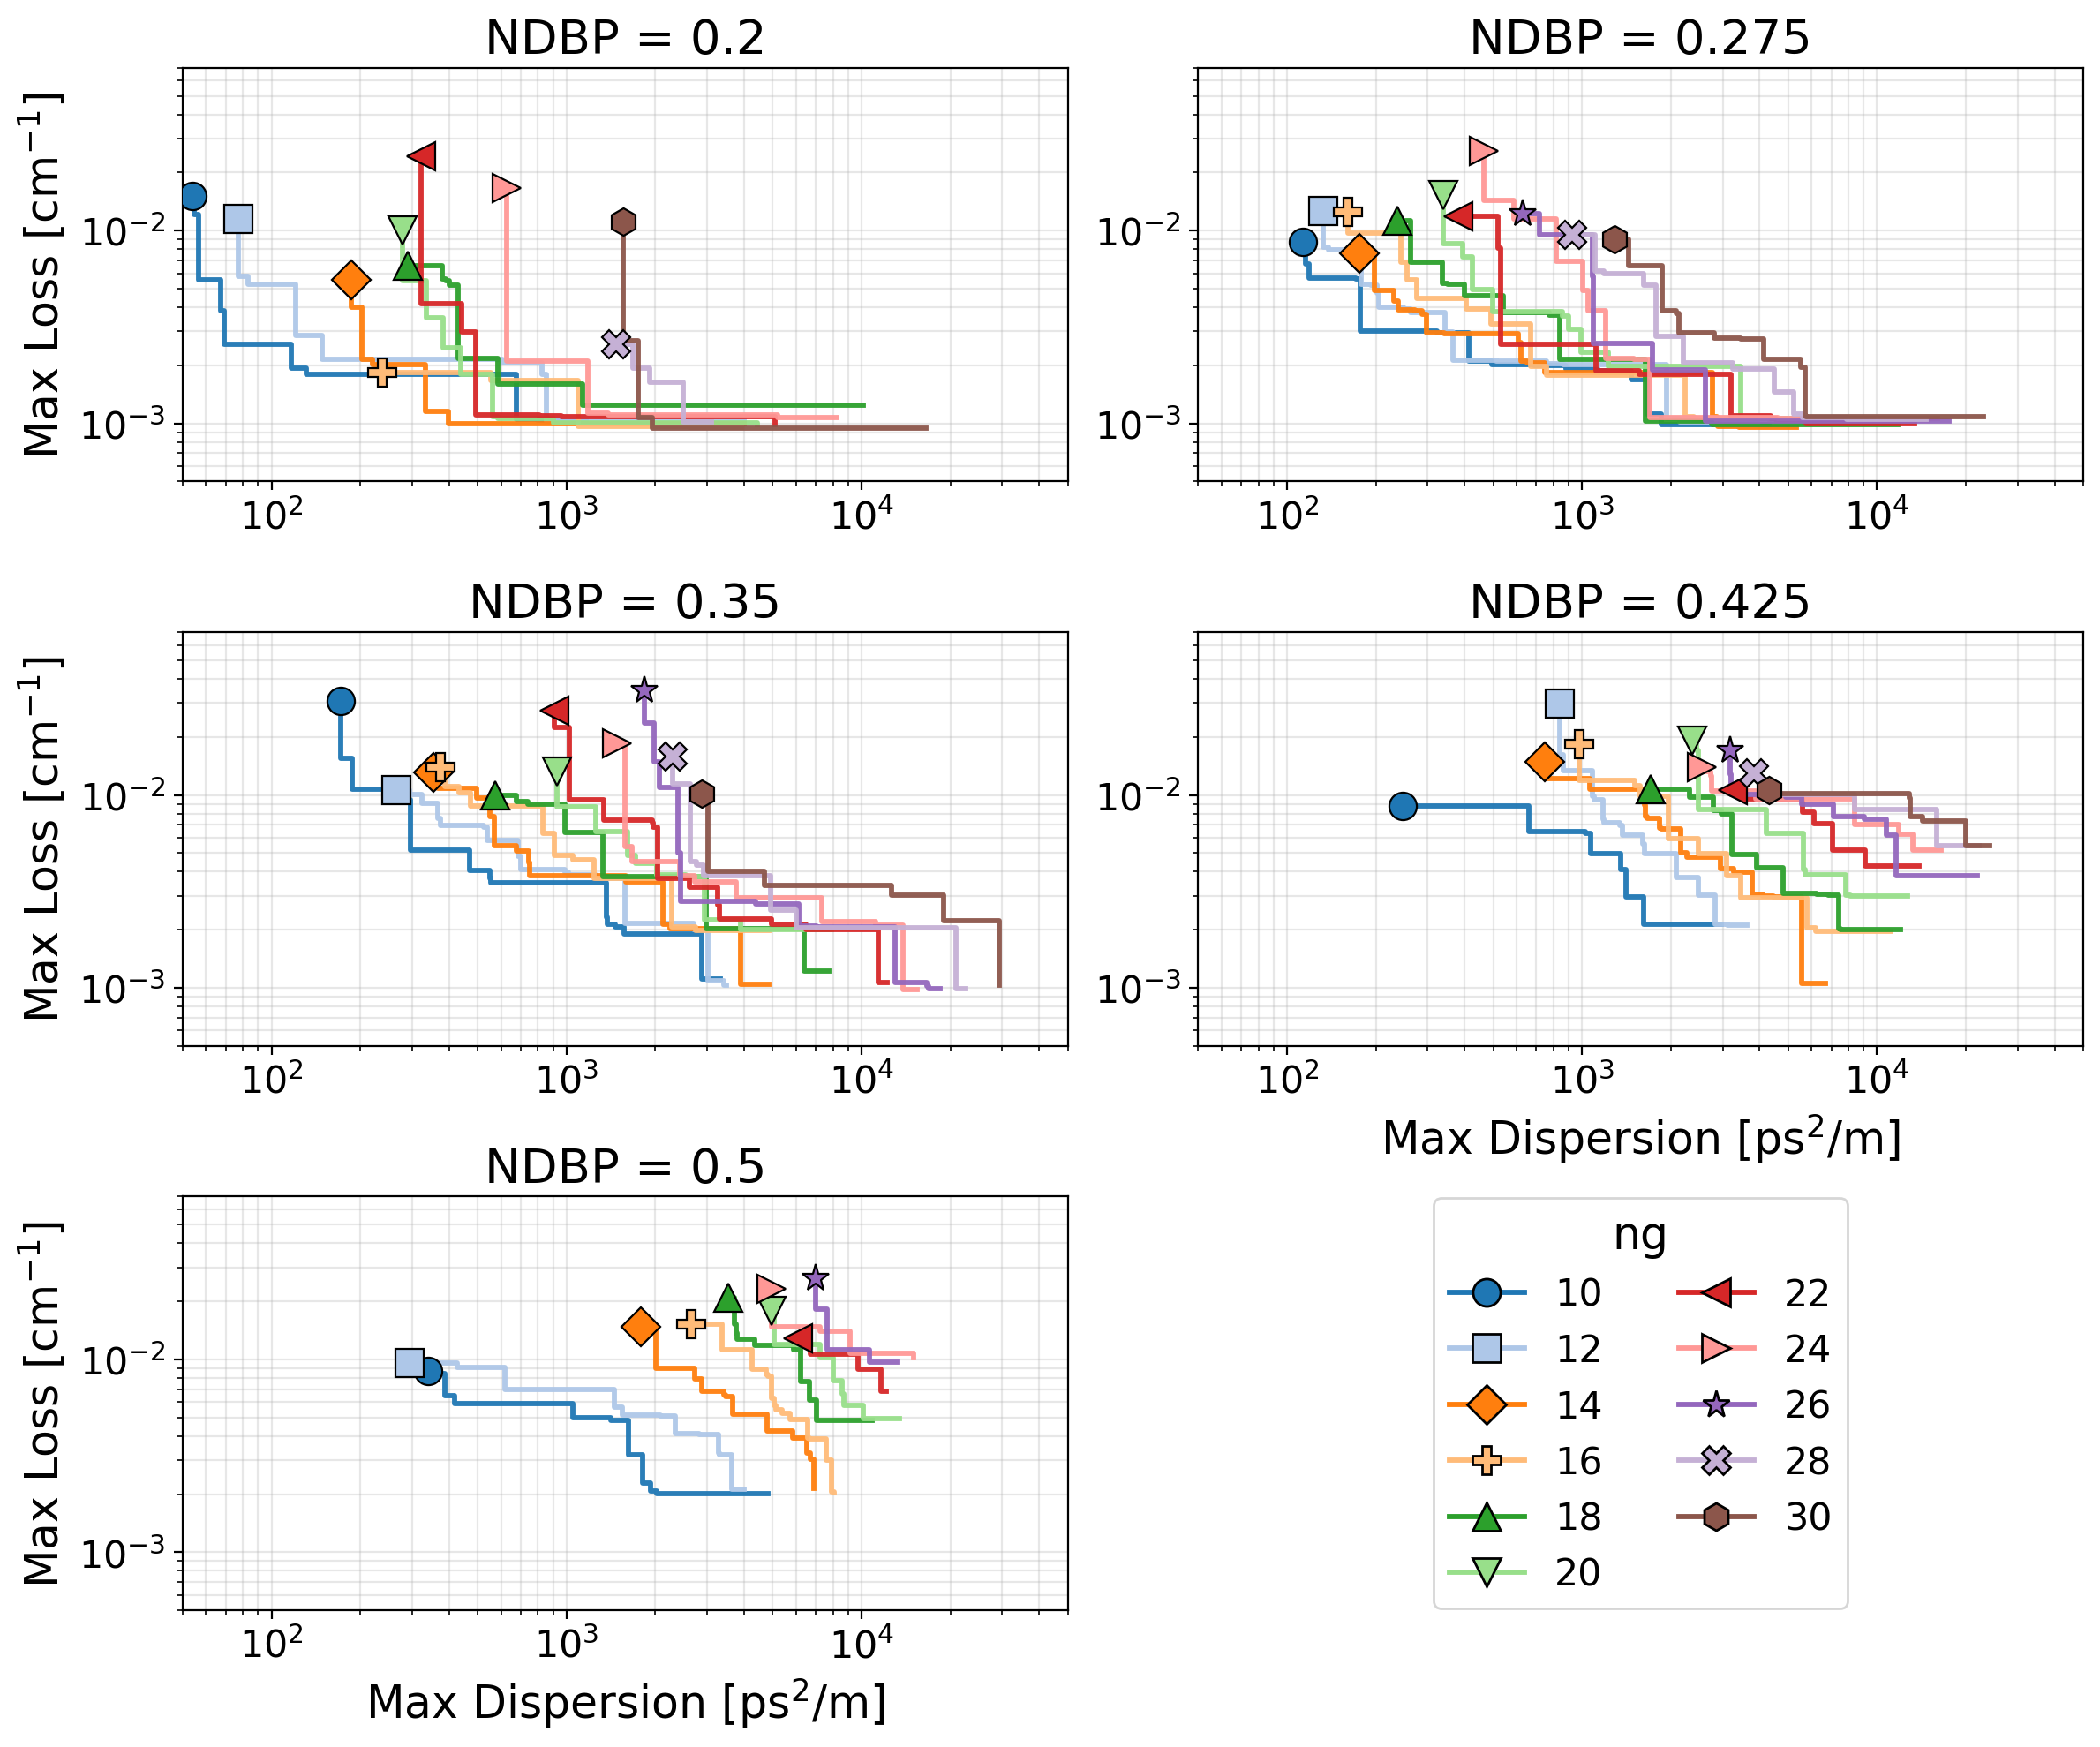

In [66]:
ng_strings = ["ng10", "ng12", "ng14", "ng16", "ng18", "ng20", "ng22", "ng24", "ng26", "ng28", "ng30"]

import matplotlib.cm as cm
import matplotlib.colors as mcolors

TEXT_SCALE = 1.4  # For scaling font/marker sizes

TRUE_COST_THRESHOLD = 1

cmap = plt.get_cmap("tab20")
ng_color_map = {ng: cmap(i % 20) for i, ng in enumerate(ng_strings)}
markers = ['o', 's', 'D', 'P', '^', 'v', '<', '>', '*', 'X', 'h']
ng_marker_map = {ng: markers[i % len(markers)] for i, ng in enumerate(ng_strings)}

ndbp_strings = ["ndbp0", "ndbp1", "ndbp2", "ndbp3", "ndbp4"]
ndbp_key = np.linspace(.2,.5,5,endpoint=True)

fig, axs = plt.subplots(3, 2, figsize=(12, 10), dpi=200)
axs = axs.flatten()

legend_handles = []
# Build legend handles once (symbols/colors for each ng)
for i, ng_string in enumerate(ng_strings):
    legend_handles.append(
        plt.Line2D(
            [0], [0],
            color=ng_color_map[ng_string],
            marker=ng_marker_map[ng_string],
            linestyle='-',
            linewidth=2.1,
            markersize=8 * TEXT_SCALE,
            label=ng_string.split("ng")[1],
            markeredgecolor='black',
            markerfacecolor=ng_color_map[ng_string]
        )
    )

for idx, ndbp_str in enumerate(ndbp_strings):
    ax = axs[idx]
    for i, ng_string in enumerate(ng_strings):
        # Only consider points with correct ndbp and true_cost < TRUE_COST_THRESHOLD
        mask = (
            (np_array["ng"] == ng_string)
            & (np_array["ndbp"] == ndbp_str)
            & (np_array["true_cost"] < TRUE_COST_THRESHOLD)
        )
        sub = np_array[mask]

        if len(sub) == 0:
            continue

        disp = np.array(sub["max_disp"])
        loss = np.array(sub["max_loss_ng2"])
        # Sort by increasing dispersion
        sort_idx = np.argsort(disp)
        disp_sorted = disp[sort_idx]
        loss_sorted = loss[sort_idx]

        # Lower envelope: running minimum of loss_sorted vs disp_sorted (skip duplicates)
        min_loss_so_far = np.minimum.accumulate(loss_sorted)
        disp_unique, idx_unique = np.unique(disp_sorted, return_index=True)
        min_loss_at_disp = min_loss_so_far[idx_unique]

        # Build data for stepwise (horizontal-vertical) lower envelope
        if len(disp_unique) > 1:
            # For a step plot, we duplicate each x (except the last) and each y (except the first)
            x_steps = []
            y_steps = []
            for j in range(len(disp_unique)):
                if j == 0:
                    x_steps.append(disp_unique[0])
                    y_steps.append(min_loss_at_disp[0])
                else:
                    # step: horizontal at previous y, up to this x
                    x_steps.append(disp_unique[j])
                    y_steps.append(min_loss_at_disp[j-1])
                    # step: vertical down to new y
                    x_steps.append(disp_unique[j])
                    y_steps.append(min_loss_at_disp[j])
            # Remove first duplicate (we want the initial (x0, y0) only once)
            x_steps = x_steps[1:]
            y_steps = y_steps[1:]

            ax.plot(
                x_steps, y_steps,
                color=ng_color_map[ng_string],
                linewidth=2.1,
                alpha=0.95,
                drawstyle="default",  # regular connection (since we manually made the steps)
                zorder=2,
                label=None  # prevent duplicate legend entries
            )

            # Draw a marker at the left-most point of each envelope line
            ax.plot(
                x_steps[0], y_steps[0],
                marker=ng_marker_map[ng_string],
                markersize=8 * TEXT_SCALE,
                color=ng_color_map[ng_string],
                linestyle='',
                markeredgecolor='black',
                markeredgewidth=0.8,
                zorder=5
            )

    ax.grid(True, alpha=0.3, which='both')
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(5e1, 5e4)
    ax.set_ylim(5e-4, 7e-2)
    if idx in [3,4]:
        ax.set_xlabel(r"Max Dispersion [ps$^2$/m]", fontsize=13 * TEXT_SCALE)
    if idx in [0,2,4]:
        ax.set_ylabel(r"Max Loss [cm$^{-1}$]", fontsize=13 * TEXT_SCALE)
    ax.tick_params(axis='both', which='major', labelsize=11 * TEXT_SCALE)
    ax.set_title(f"NDBP = {ndbp_key[int(ndbp_str.split('p')[1])]}", fontsize=14 * TEXT_SCALE)

# Remove axis and add legend to last unoccupied (6th) subplot
ax_legend = axs[-1]
ax_legend.axis('off')
ax_legend.legend(
    handles=legend_handles,
    loc='center',
    fontsize=11 * TEXT_SCALE,
    title="ng", title_fontsize=13 * TEXT_SCALE,
    ncol=2,
    frameon=True
)

plt.tight_layout()
plt.show()


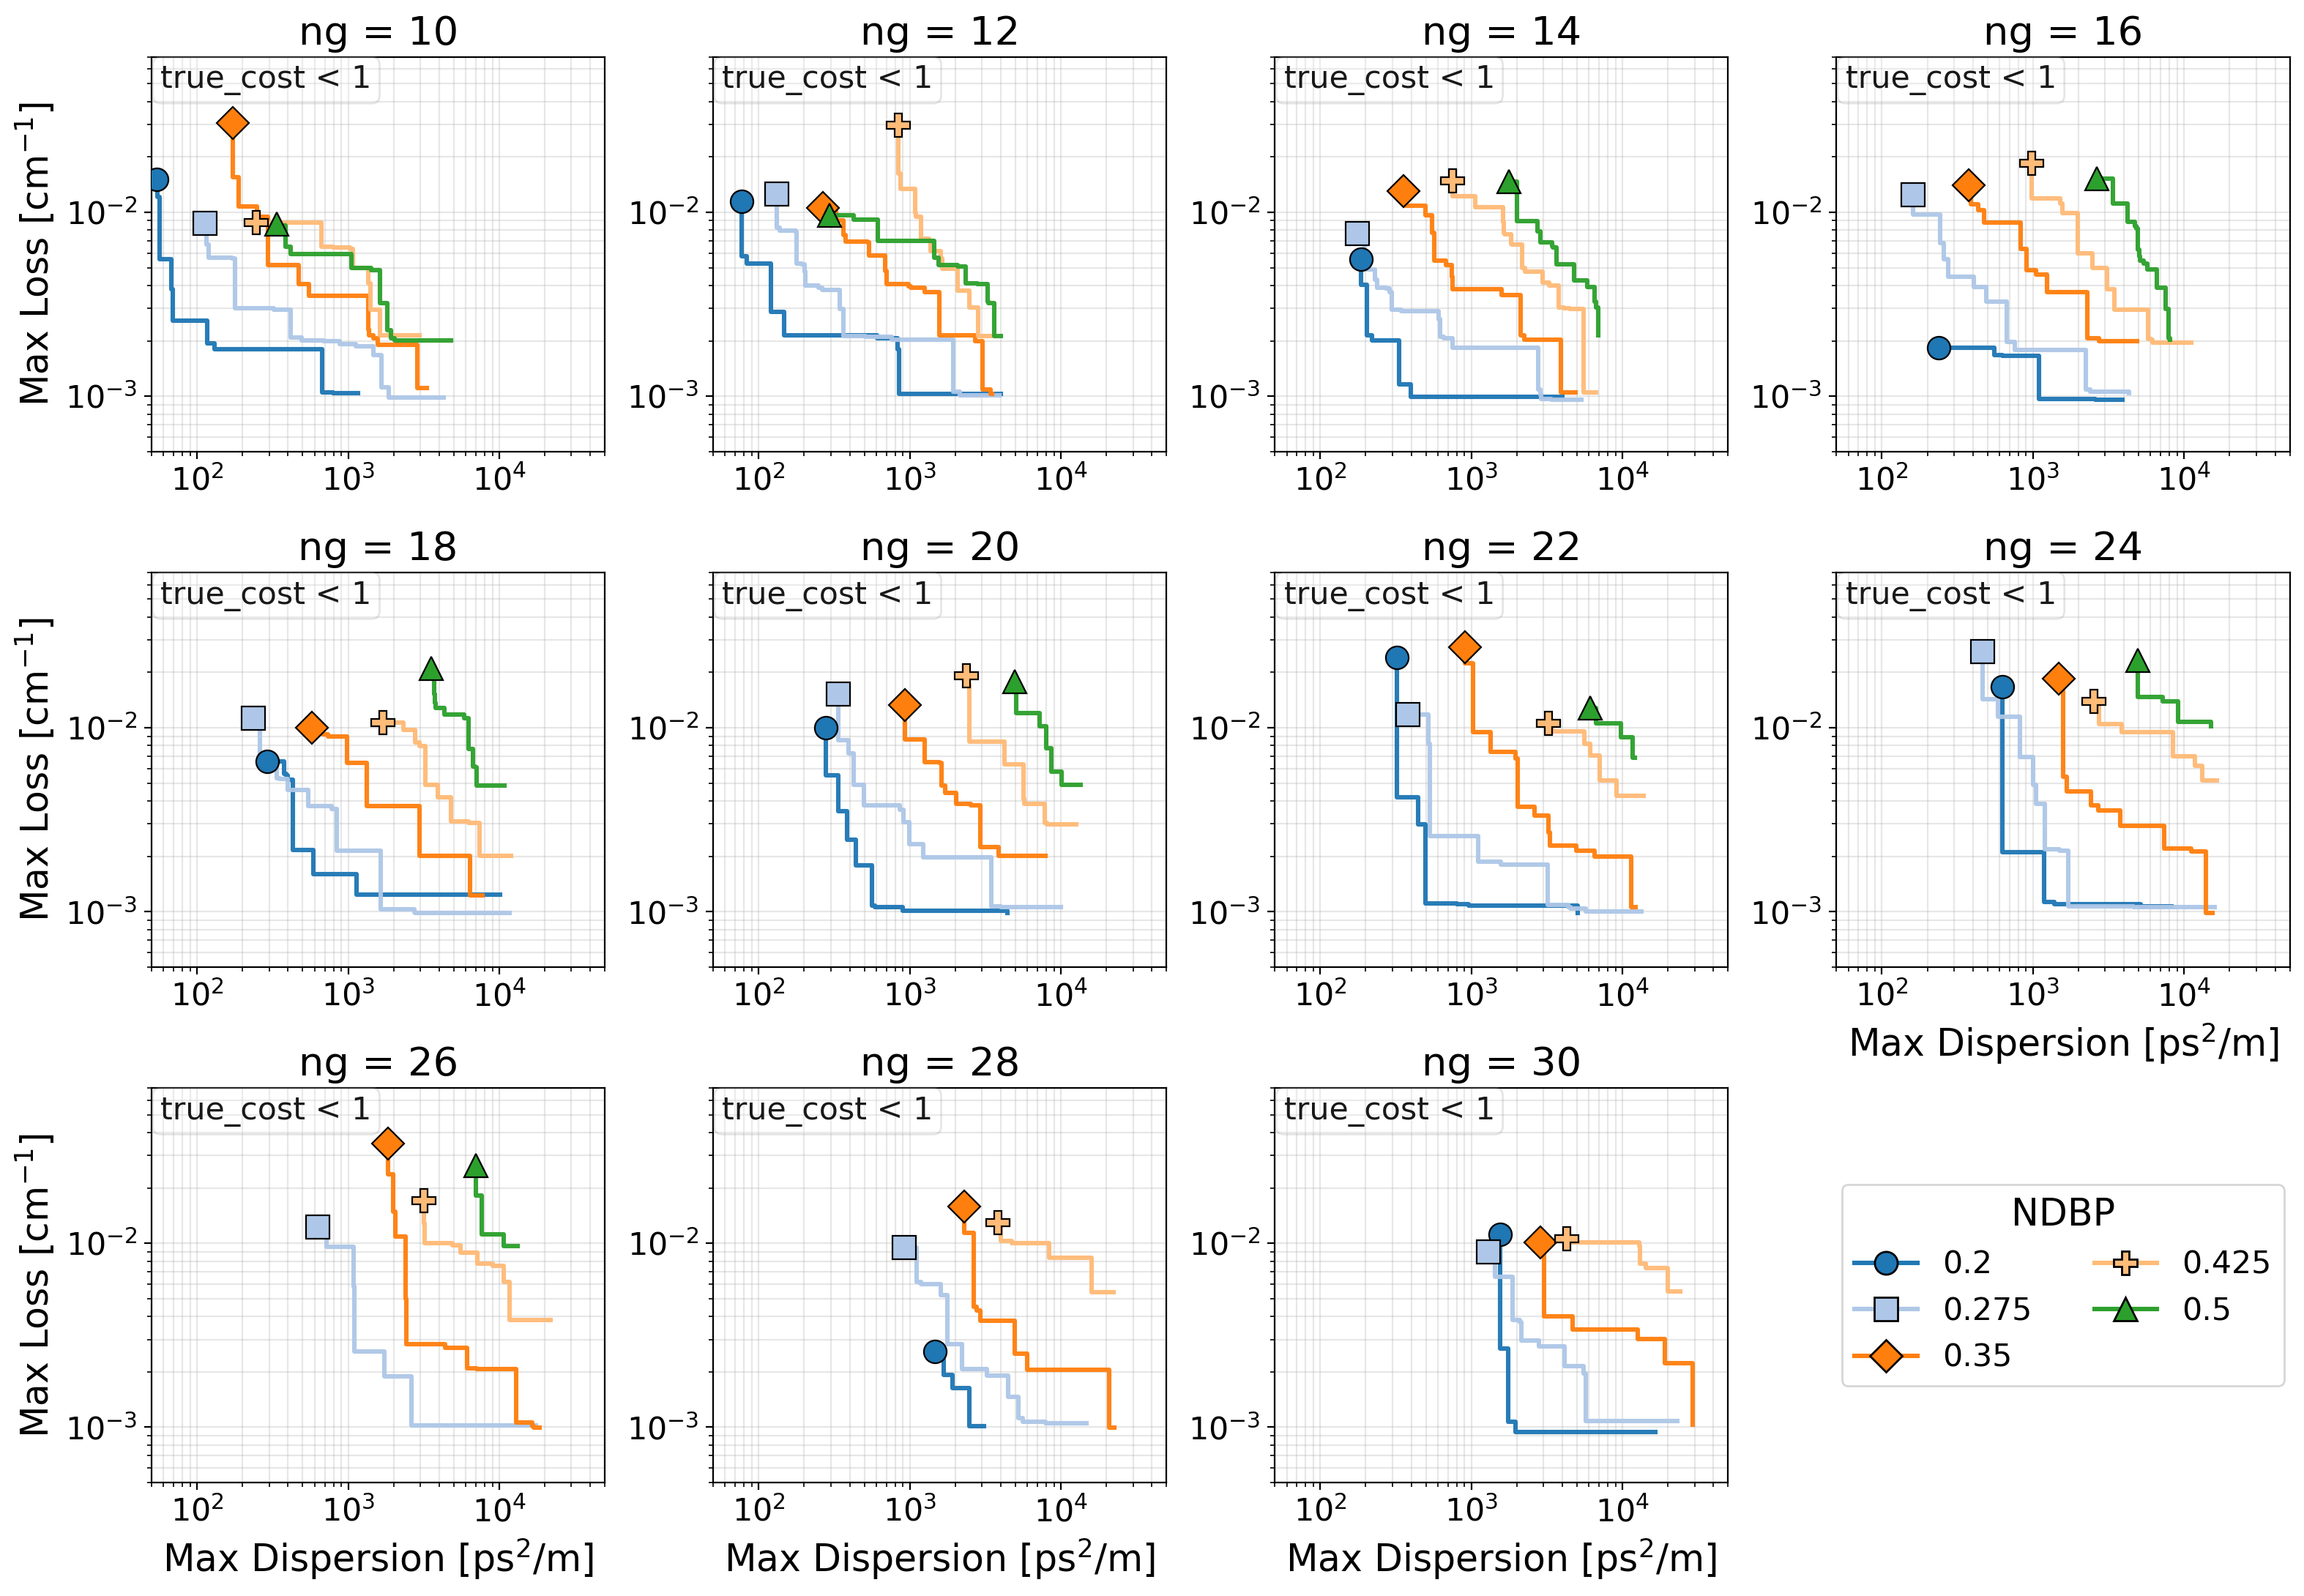

In [64]:
ng_strings = ["ng10", "ng12", "ng14", "ng16", "ng18", "ng20", "ng22", "ng24", "ng26", "ng28", "ng30"]

import matplotlib.cm as cm
import matplotlib.colors as mcolors

TEXT_SCALE = 1.4  # For scaling font/marker sizes
TRUE_COST_THRESHOLD = 1

cmap = plt.get_cmap("tab20")
ndbp_strings = ["ndbp0", "ndbp1", "ndbp2", "ndbp3", "ndbp4"]
ndbp_color_map = {ndbp: cmap(i % 20) for i, ndbp in enumerate(ndbp_strings)}
ndbp_markers = ['o', 's', 'D', 'P', '^', 'v', '<', '>', '*', 'X', 'h']
ndbp_marker_map = {ndbp: ndbp_markers[i % len(ndbp_markers)] for i, ndbp in enumerate(ndbp_strings)}

fig, axs = plt.subplots(3, 4, figsize=(16, 11), dpi=200)
axs = axs.flatten()

legend_handles = []
# Build legend handles for each ndbp (since lines are for ndbp now)
for i, ndbp_str in enumerate(ndbp_strings):
    legend_handles.append(
        plt.Line2D(
            [0], [0],
            color=ndbp_color_map[ndbp_str],
            marker=ndbp_marker_map[ndbp_str],
            linestyle='-',
            linewidth=2.2,
            markersize=8 * TEXT_SCALE,
            label=ndbp_key[int(ndbp_str.split('p')[1])],
            markeredgecolor='black',
            markerfacecolor=ndbp_color_map[ndbp_str]
        )
    )

for idx, ng_string in enumerate(ng_strings):
    if idx >= len(axs)-1:  # Leave last subplot free for legend
        continue
    ax = axs[idx]
    for i, ndbp_str in enumerate(ndbp_strings):
        # Only consider points with correct ng and true_cost < TRUE_COST_THRESHOLD
        mask = (
            (np_array["ng"] == ng_string)
            & (np_array["ndbp"] == ndbp_str)
            & (np_array["true_cost"] < TRUE_COST_THRESHOLD)
        )
        sub = np_array[mask]

        if len(sub) == 0:
            continue

        disp = np.array(sub["max_disp"])
        loss = np.array(sub["max_loss_ng2"])
        # Sort by increasing dispersion
        sort_idx = np.argsort(disp)
        disp_sorted = disp[sort_idx]
        loss_sorted = loss[sort_idx]

        # Lower envelope: running minimum of loss_sorted vs disp_sorted (skip duplicates)
        min_loss_so_far = np.minimum.accumulate(loss_sorted)
        disp_unique, idx_unique = np.unique(disp_sorted, return_index=True)
        min_loss_at_disp = min_loss_so_far[idx_unique]

        # Build data for stepwise (horizontal-vertical) lower envelope
        if len(disp_unique) > 1:
            # For a step plot, we duplicate each x (except the last) and each y (except the first)
            x_steps = []
            y_steps = []
            for j in range(len(disp_unique)):
                if j == 0:
                    x_steps.append(disp_unique[0])
                    y_steps.append(min_loss_at_disp[0])
                else:
                    # step: horizontal at previous y, up to this x
                    x_steps.append(disp_unique[j])
                    y_steps.append(min_loss_at_disp[j-1])
                    # step: vertical down to new y
                    x_steps.append(disp_unique[j])
                    y_steps.append(min_loss_at_disp[j])
            # Remove first duplicate (we want the initial (x0, y0) only once)
            x_steps = x_steps[1:]
            y_steps = y_steps[1:]

            ax.plot(
                x_steps, y_steps,
                color=ndbp_color_map[ndbp_str],
                linewidth=2.2,
                alpha=0.96,
                drawstyle="default",  # regular connection (since we manually made the steps)
                zorder=2,
                label=ndbp_str if idx == 0 else None  # legend only once, but not strictly needed due to manual legend
            )

            # Draw a marker at the left-most point of each envelope line
            ax.plot(
                x_steps[0], y_steps[0],
                marker=ndbp_marker_map[ndbp_str],
                markersize=8 * TEXT_SCALE,
                color=ndbp_color_map[ndbp_str],
                label=None,
                linestyle='',
                markeredgecolor='black',
                markeredgewidth=0.8,
                zorder=5
            )

    ax.grid(True, alpha=0.3, which='both')
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(5e1, 5e4)
    ax.set_ylim(5e-4, 7e-2)
    if idx in [7,8,9,10]:
        ax.set_xlabel(r"Max Dispersion [ps$^2$/m]", fontsize=13 * TEXT_SCALE)
    if idx in [0,4,8]:
        ax.set_ylabel(r"Max Loss [cm$^{-1}$]", fontsize=13 * TEXT_SCALE)
    ax.tick_params(axis='both', which='major', labelsize=11 * TEXT_SCALE)
    ax.set_title(f"ng = {ng_string.split('ng')[1]}", fontsize=14 * TEXT_SCALE)
    # Threshold annotation
    ax.text(
        0.02, 0.98, f"true_cost < {TRUE_COST_THRESHOLD}",
        transform=ax.transAxes, ha="left", va="top",
        fontsize=11 * TEXT_SCALE, color="k", alpha=0.9,
        bbox=dict(facecolor='w', edgecolor='gray', alpha=0.2, boxstyle='round,pad=0.25')
    )

# Remove axis and add legend to last unoccupied (12th) subplot
ax_legend = axs[-1]
ax_legend.axis('off')
ax_legend.legend(
    handles=legend_handles,
    loc='center',
    fontsize=11 * TEXT_SCALE,
    title="NDBP", title_fontsize=13 * TEXT_SCALE,
    ncol=2,
    frameon=True
)

plt.tight_layout()
plt.show()